In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/uts_ai')

UTS

In [8]:

import librosa
import librosa.feature
import librosa.display
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import tensorflow as tf 

Using TensorFlow backend.


In [0]:
def display_mfcc(song):
    y, _ = librosa.load(song)
    mfcc = librosa.feature.mfcc(y)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time', y_axis='mel')
    plt.colorbar()
    plt.title(song)
    plt.tight_layout()
    plt.show()

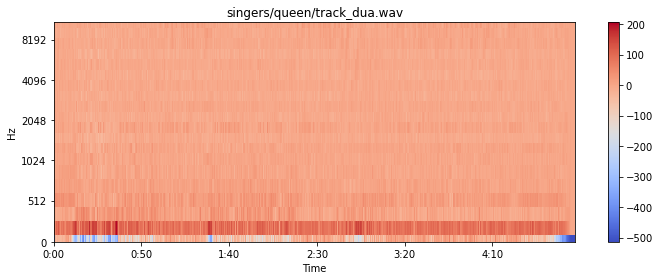

In [10]:

display_mfcc('singers/queen/track_dua.wav')



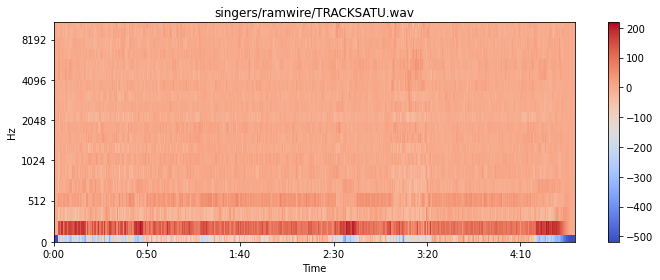

In [11]:
display_mfcc('singers/ramwire/TRACKSATU.wav')

In [0]:
def extract_features_song(f):
    y, _ = librosa.load(f)
    # get Mel-frequency cepstral coefficients
    mfcc = librosa.feature.mfcc(y)
    # normalize values between -1,1 (divide by max)
    mfcc /= np.amax(np.absolute(mfcc))
    return np.ndarray.flatten(mfcc)[-60000:]

In [13]:
extract_features_song('singers/ramwire/TRACKSATU.wav')

array([0.01695491, 0.01815965, 0.02561506, ..., 0.        , 0.        ,
       0.        ])

In [15]:
extract_features_song('singers/queen/track_dua.wav')

array([0.01278674, 0.01836715, 0.01766969, ..., 0.        , 0.        ,
       0.        ])

In [0]:
def generate_features_and_labels():
    all_features = []
    all_labels = []

    singers = ['aerosmith', 'airsupply', 'bonjovi', 'bright', 'gunnroses', 'kananisino', 'ledzeppelin', 'mrbig', 'queen', 'radwimps', 'ramwire']
    for singer in singers:
        sound_files = glob.glob('singers/'+singer+'/*.wav')
        print('Processing %d songs by %s ...' % (len(sound_files), singer))
        
        for f in sound_files:
            features = extract_features_song(f)
            all_features.append(features)
            all_labels.append(singer)

    # convert labels to one-hot encoding
    label_uniq_ids, label_row_ids = np.unique(all_labels, return_inverse=True)
    label_row_ids = label_row_ids.astype(np.int32, copy=False)
    onehot_labels = to_categorical(label_row_ids, len(label_uniq_ids))
    return np.stack(all_features), onehot_labels

In [29]:
features, labels = generate_features_and_labels()



Processing 10 songs by aerosmith ...
Processing 10 songs by airsupply ...
Processing 10 songs by bonjovi ...
Processing 10 songs by bright ...
Processing 0 songs by gunnroses ...
Processing 10 songs by kananisino ...
Processing 10 songs by ledzeppelin ...
Processing 10 songs by mrbig ...
Processing 10 songs by queen ...
Processing 10 songs by radwimps ...
Processing 10 songs by ramwire ...


In [30]:

print(np.shape(features))
print(np.shape(labels))

training_split = 0.8

# last column has genre, turn it into unique ids
alldata = np.column_stack((features, labels))

np.random.shuffle(alldata)
splitidx = int(len(alldata) * training_split)
train, test = alldata[:splitidx,:], alldata[splitidx:,:]

print(np.shape(train))
print(np.shape(test))


train_input = train[:,:-10]
train_labels = train[:,-10:]

test_input = test[:,:-10]
test_labels = test[:,-10:]

print(np.shape(train_input))
print(np.shape(train_labels))

print(np.shape(test_input))
print(np.shape(test_labels))


(100, 60000)
(100, 10)
(80, 60010)
(20, 60010)
(80, 60000)
(80, 10)
(20, 60000)
(20, 10)


In [31]:

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(100, input_dim=np.shape(train_input)[1]))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Activation('softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               6000100   
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 6,001,110
Trainable params: 6,001,110
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
model.fit(train_input, train_labels, epochs=10, batch_size=32,
          validation_split=0.2)

loss, acc = model.evaluate(test_input, test_labels, batch_size=32)

print("Done!")
print("Loss: %.4f, accuracy: %.4f" % (loss, acc))
# save the trained model
model.save("singers.hdf5")

Epoch 1/10
2/2 [==============================] - 0s 125ms/step - loss: 2.3050 - accuracy: 0.0938 - val_loss: 2.1557 - val_accuracy: 0.1875
Epoch 2/10
2/2 [==============================] - 0s 46ms/step - loss: 1.4812 - accuracy: 0.8594 - val_loss: 2.0157 - val_accuracy: 0.2500
Epoch 3/10
2/2 [==============================] - 0s 45ms/step - loss: 0.8545 - accuracy: 0.9844 - val_loss: 1.9235 - val_accuracy: 0.4375
Epoch 4/10
2/2 [==============================] - 0s 45ms/step - loss: 0.4457 - accuracy: 1.0000 - val_loss: 1.8772 - val_accuracy: 0.3750
Epoch 5/10
2/2 [==============================] - 0s 48ms/step - loss: 0.2226 - accuracy: 1.0000 - val_loss: 1.8458 - val_accuracy: 0.3750
Epoch 6/10
2/2 [==============================] - 0s 51ms/step - loss: 0.1156 - accuracy: 1.0000 - val_loss: 1.8307 - val_accuracy: 0.3750
Epoch 7/10
2/2 [==============================] - 0s 44ms/step - loss: 0.0582 - accuracy: 1.0000 - val_loss: 1.8319 - val_accuracy: 0.4375
Epoch 8/10
2/2 [==========

In [33]:
model2 = tf.keras.models.load_model("singers.hdf5")
print(model2.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               6000100   
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 6,001,110
Trainable params: 6,001,110
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
def predict(song_path):
    song = np.stack([extract_features_song(song_path)])
    # do the prediction
    prediction = model2.predict(song, batch_size=32)

    print("Prediction: %s, confidence: %.2f" % (np.argmax(prediction), np.max(prediction)))


In [36]:
predict('singers/ramwire/TRACKSATU.wav')


Prediction: 9, confidence: 0.99


In [41]:
pred_labels = model2.predict(test_input)
cm = confusion_matrix(test_labels.argmax(axis=1), pred_labels.argmax(axis=1))
cm


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [2, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(6,6), dpi=100)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Normalized confusion matrix
[[       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.33333333 0.         0.         0.33333333 0.         0.
  0.         0.         0.33333333 0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.5        0.         0.
  0.         0.         0.         0.5       ]
 [0.33333333 0.         0.         0.         0.         0.33333333
  0.         0.         0.33333333 0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.5        0.25       0.         0.         0.         0.25
  0.         0.         0.         0.        ]
 [0.66666667 0.         0.         0.         0.         0.
  0.         0.         0.33333333 0. 

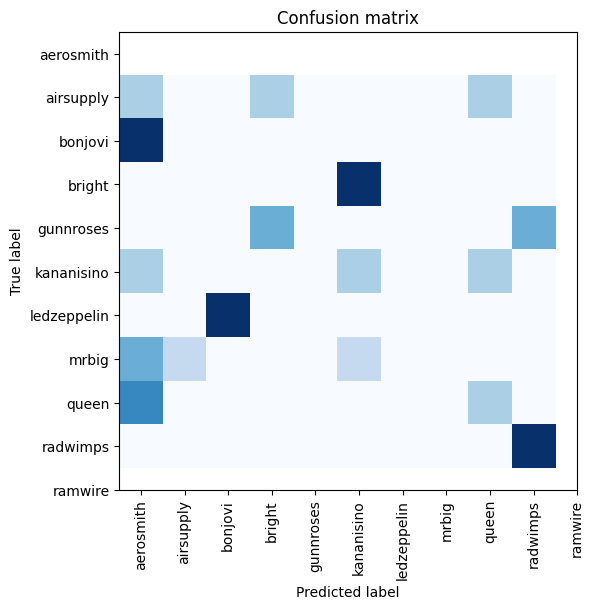

In [43]:
singers = ['aerosmith', 'airsupply', 'bonjovi', 'bright', 'gunnroses', 'kananisino', 'ledzeppelin', 'mrbig', 'queen', 'radwimps', 'ramwire']
plot_confusion_matrix(cm, classes=singers, normalize=True)
plt.show()